# Data Access with Butler


This notebook demonstrates how to use `Butler` objects from the DM stack to parse and manipulate data. After finishing this notebook, users will know how to:

 - Load and access a data repository using `Butler`
 - Select subsets of data and convert data into familiar data structures
 - Use `Butler` to access coordinate information and cutout postage stamps
 - Use `Butler` to access a skymap
 

## Core Concepts

`Butler` provides a way to access information using a uniform interface without needing to keep track of how the information is internally stored or organized. Data access with `Butler` has three levels you need to be aware of:

1. Each instantiated `Butler` object provides access to a collection of datasets called a **repository**. Each repository is defined by Butler using the local file directory where the data is stored.
1. Each data set in a **repository** is assigned a unique name called a **type**. These types are strings that describe the data set and should not be confused with an "object type" as defined by Python.
1. Individual entries in a data set are identified using a unique **data identifier**, which is a dictionary who's allowed keys and values depend on the data set you are working with.


In [1]:
import matplotlib.pyplot as plt

import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import matplotlib.pyplot as plt
from lsst.daf.persistence import Butler
from lsst.geom import SpherePoint

%matplotlib inline


## Loading Data

To start we instantialize a `Butler` object by providing it with the directory of the **repository** we want to access. Next we load a **type** of dataset and select data from a single **data identifier**. For this demonstration we consider the `deepCoadd_ref` dataset which contains tables of information concerning coadded images used in the differencing image pipeline. The id values for this data set include two required values: `tract` and `patch` which denote sections of the sky.


In [2]:
repo = '/global/cscratch1/sd/rearmstr/new_templates/diffim_template'
butler = Butler(repo)


In [3]:
# We choose an arbitrary tract and patch. 
data_id = {'tract': 4849, 'patch': '6,6'}
dataset_type = 'deepCoadd_ref'

# We can check that the data exists before we try to read it
data_exists = butler.datasetExists(datasetType=dataset_type, dataId=data_id)
print('Data exists for ID:', data_exists)

data_entry = butler.get(dataset_type, dataId=data_id)
data_entry


Data exists for ID: True


<class 'lsst.afw.table.source.source.SourceCatalog'>
        id             coord_ra      ... merge_measurement_g merge_measurement_u
                         rad         ...                                        
----------------- ------------------ ... ------------------- -------------------
21326977935867905 0.9283615729464572 ...               False               False
21326977935867906 0.9283009242109512 ...               False               False
21326977935867907 0.9281642074368622 ...               False               False
21326977935867908 0.9280969306485073 ...               False               False
21326977935867909 0.9278675638613414 ...               False               False
21326977935867910 0.9275036833090777 ...               False               False
21326977935867911 0.9272544712516174 ...               False               False
21326977935867912 0.9271651545630288 ...               False               False
21326977935867913 0.9267406273478027 ...               F

The data table returned above is formatted as a `SourceCatalog` object, which is essentially a collection of `numpy` arrays. We can see this when we index a particular column. 

In [4]:
print(type(data_entry['merge_measurement_i']))


<class 'numpy.ndarray'>


`SourceCatalog` objects have their own set of methods for table manipulations (sorting, appending rows, et.). However, we can also work with the data in a more familiar format, such as an astropy `Table` or a pandas `DataFrame`. 

In [5]:
data_frame = data_entry.asAstropy().to_pandas()
data_frame.head()


,id,coord_ra,coord_dec,parent,merge_footprint_i,merge_footprint_r,merge_footprint_z,merge_footprint_y,merge_footprint_g,merge_footprint_u,...,slot_ModelFlux_initial_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,merge_measurement_i,merge_measurement_r,merge_measurement_z,merge_measurement_y,merge_measurement_g,merge_measurement_u
0,21326977935867905,0.928362,-0.496660,0,True,False,False,False,False,False,...,False,NaN,True,295,True,False,False,False,False,False
1,21326977935867906,0.928301,-0.496659,0,True,False,False,False,False,False,...,False,NaN,True,29,True,False,False,False,False,False
2,21326977935867907,0.928164,-0.496656,0,True,False,False,False,False,False,...,False,NaN,True,498,True,False,False,False,False,False
3,21326977935867908,0.928097,-0.496657,0,True,False,False,False,False,False,...,False,NaN,True,44,True,False,False,False,False,False
4,21326977935867909,0.927868,-0.496657,0,True,False,False,False,False,False,...,False,NaN,True,262,True,False,False,False,False,False


It is important to note that `Butler` objects are not required to return tabular data. We will see an example of this later when we load and parse image data.

## Selecting Subsets of Data

In practice you may not know the format of the data identifier for a given data set. In this case the `getKeys()` method can be used to determine the key values expected in a **data identifier**. 


In [6]:
data_id_format = butler.getKeys(dataset_type)
print('Expected data id format:', data_id_format)


Expected data id format: {'tract': <class 'int'>, 'patch': <class 'str'>}


It is import to note that the `getKeys` method will only specify key values that are required by the data set. We can also include optional key values to further select a subset of the data. Lets say we only wanted table entries where `merge_footprint_i` has a value of `True`. We could retrieve the data and subselect the values of the returned table, or we can do simply specify the condition in the data id.

In [7]:
new_data_id = {'tract': 4849, 'patch': '6,6', 'merge_footprint_i': True}
merged_i_data = butler.get(dataset_type, dataId=new_data_id)

# Check that the returned table does in fact have only entries where
# merge_footprint_i is True
merged_i_data['merge_measurement_i'].all()


True

Although you can't specify complex conditionals in a data id, you can use it so perform simple selections. You can also can also select a select all complete dataIds for a dataset type that match a partial (or empty) dataId. For example, the below cell iterates over all possible ids and checks if the corresponding file exists.


In [8]:
subset = butler.subset(dataset_type, dataId=data_id)
id_list = [dr.dataId for dr in subset if dr.datasetExists()]
print(f'fAvailable Ids:\n {id_list}')


fAvailable Ids:
 [DataId(initialdata={'tract': 4849, 'patch': '6,6'}, tag=set())]


## Creating Postage Stamps

When dealing with image data, we can use `Butler` to generate postage stamps at a given set of coordinates. For this example we consider the `deepCoadd` data set, which has one extra key value than the previous example.

In [9]:
coadd_type = 'deepCoadd'
butler.getKeys(coadd_type)


{'filter': str, 'tract': int, 'patch': str}

In order to generate a postage stamp, we define the center an size of the cutout using 

In [10]:
# Retrieve the image using butler
coadd_id = {'tract': 4849, 'patch': '6,6', 'filter': 'z'}
image = butler.get(coadd_type, dataId=coadd_id)

# Define the center and size of our cutout
ra, dec = 53.135801, -28.426165
radec = SpherePoint(ra, dec, afwGeom.degrees)
cutout_size = 75
cutout_extent = afwGeom.ExtentI(cutout_size, cutout_size)

# Cutout and optionally save the postage stamp to file
postage_stamp = image.getCutout(radec, cutout_extent)
# postage_stamp.writeFits(<output_filename>)


Since the postage stamp was generated using `Butler`, we can plot it using the DM `afwDisplay` module.

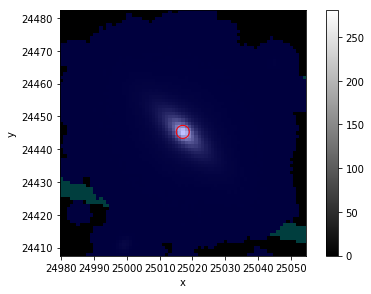

In [11]:
xy = postage_stamp.getWcs().skyToPixel(radec)

display = afwDisplay.Display(frame=1, backend='matplotlib')
display.mtv(postage_stamp)
display.scale("linear", "zscale")
display.dot('o', xy.getX(), xy.getY(), ctype='red')
display.show_colorbar()

plt.xlabel('x')
plt.ylabel('y')
plt.show()


It is important to note that the cutout image is aware of what the pixel values were in the original image. This is why the axis labels in the above cutout are so large. We also note that the orientation of the postage stamp is in the x, y orientation of the original coadded image.


## Selecting an Area on the Sky with a Sky Map

As a final example, we consider a third type of data that can be accessed via `Butler` called `skymap`. Sky maps allow you to look up information for a given `tract` and `patch`. You may notice from the below example that data set **types** tend to follow the convertion of having a base name (e.g. `'deepCoadd'`) followed by a descriptor (e.g. `'_skyMap'`).

In [12]:
skymap = butler.get('deepCoadd_skyMap')
tract_info = skymap[4849]
tract_info


TractInfo(id=4849, ctrCoord=[0.5161225807000198, 0.7060132991362492, -0.4849357721743165])

In [13]:
patch_info = tract_info.getPatchInfo((6,6))
patch_info


PatchInfo(index=(6, 6), innerBBox=(minimum=(24000, 24000), maximum=(27999, 27999)), outerBBox=(minimum=(23900, 23900), maximum=(27999, 27999)))

In [14]:
tract_bbox = tract_info.getBBox()
tract_pix_corners = afwGeom.Box2D(tract_bbox).getCorners()
print('Tract corners in pixels:\n', tract_pix_corners)

wcs = tract_info.getWcs()
tract_deg_corners = wcs.pixelToSky(tract_pix_corners)
tract_deg_corners = [[c.getRa().asDegrees(), c.getDec().asDegrees()] for c in tract_deg_corners]
print('\nTract corners in degrees:\n', tract_deg_corners)


Tract corners in pixels:
 [Point2D(-0.5, -0.5), Point2D(27999.5, -0.5), Point2D(27999.5, 27999.5), Point2D(-0.5, 27999.5)]

Tract corners in degrees:
 [[54.72776196140405, -29.78294629153197], [52.93572544959448, -29.78294586008059], [52.9491120046228, -28.2276731919467], [54.71437636206343, -28.2276735966408]]
